In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas_datareader as predict
key=""
df = pdr.get_data_tiingo("AAPL", api_key=key)
df.to_csv("AAPL.csv")

In [11]:
df1 = pd.read_csv("AAPL.csv")
df1.head(3)

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.26,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.95,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.45,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0


In [12]:
df2 = df1.reset_index()["close"]
df2.head(3)

0    132.045
1    131.780
2    130.280
Name: close, dtype: float64

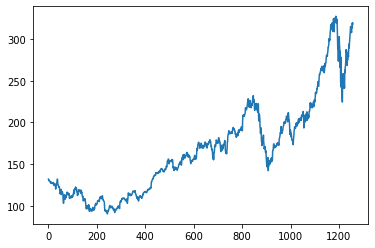

In [14]:
plt.plot(df2)

We apply MinMax scaler to the data because LSTM are sensitive to scale

In [17]:
df2

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler = MinMaxScaler()
df3 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df3

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

Splitting dataset into train and test datasets

In [21]:
train_size = int(len(df3)*0.7)
test_size = len(df3) - train_size
train_data, test_data = df3[:train_size, :], df3[train_size:len(df3), :1]

In [22]:
train_size, test_size

(880, 378)

Convert array into dataset matrix

In [23]:
def dataset_matrix(dataset, time_step=1):
  x_data, y_data = [], []
  for i in range(len(dataset)-time_step-1):
    m = dataset[i:(i+time_step), 0]
    x_data.append(m)
    y_data.append(dataset[i+time_step, 0])
  return np.array(x_data), np.array(y_data)

In [25]:
time_step = 100
x_train, y_train = dataset_matrix(train_data, time_step)
x_test, y_test = dataset_matrix(test_data, time_step)

In [26]:
x_train.shape, y_train.shape

((779, 100), (779,))

In [27]:
x_test.shape, y_test.shape

((277, 100), (277,))

In [28]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

**LSTM Model**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [30]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 10s 316ms/step - loss: 0.0166 - val_loss: 0.0657
Epoch 2/100
13/13 [==============================] - 3s 194ms/step - loss: 0.0035 - val_loss: 0.0070
Epoch 3/100
13/13 [==============================] - 2s 188ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 4/100
13/13 [==============================] - 2s 189ms/step - loss: 8.9517e-04 - val_loss: 0.0044
Epoch 5/100
13/13 [==============================] - 2s 191ms/step - loss: 8.2207e-04 - val_loss: 0.0047
Epoch 6/100
13/13 [==============================] - 2s 189ms/step - loss: 7.3331e-04 - val_loss: 0.0050
Epoch 7/100
13/13 [==============================] - 2s 191ms/step - loss: 6.7208e-04 - val_loss: 0.0061
Epoch 8/100
13/13 [==============================] - 3s 198ms/step - loss: 6.7611e-04 - val_loss: 0.0063
Epoch 9/100
13/13 [==============================] - 2s 188ms/step - loss: 6.4966e-04 - val_loss: 0.0079
Epoch 10/100
13/13 [==============================] - 2s 189ms/ste

In [34]:
import tensorflow as tf
tf.__version__

'2.8.2'

Prediction

In [35]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [36]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Calculating RMSE for performance measurement

In [37]:
import math
from sklearn.metrics import mean_squared_error
# train data RMSE
math.sqrt(mean_squared_error(y_train, train_predict))

147.5411997868494

In [39]:
# test data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

240.40391827402064

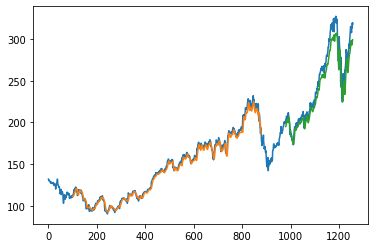

In [41]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df3))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [42]:
len(test_data)

378

In [43]:
x_input = test_data[278:].reshape(1,-1)

In [44]:
x_input.shape

(1, 100)

In [46]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [47]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

**Predicting for next 10 days**

In [48]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.8969372]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

In [50]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [51]:
len(df3)

1258

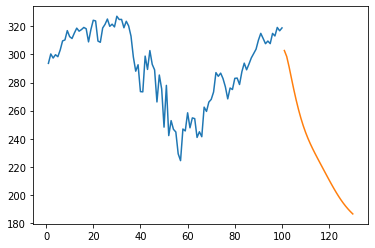

In [53]:
plt.plot(day_new,scaler.inverse_transform(df3[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

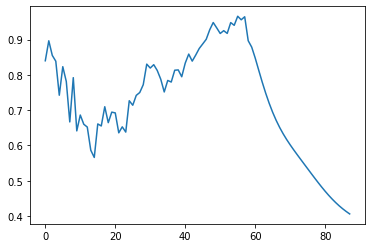

In [55]:
df4=df3.tolist()
df4.extend(lst_output)
plt.plot(df4[1200:])

In [56]:
df4=scaler.inverse_transform(df4).tolist()

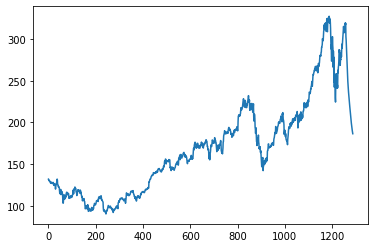

In [57]:
plt.plot(df4)